# `BasisMatrices.jl`: Examples

This is an overview of how to use the main features of the package. 

## Setting up a Basis Structure

Let's suppose that we want to set up a two-dimensional basis over grids for two variables, $y$ and $a$. Create the grids as follows:

In [1]:
ygrid0 = range(-4; stop=4, length=10)
agrid0 = range(0.0.^0.4; stop=100.0.^0.4, length=25).^(1/0.4);

We first need to create a `Basis` object. This will contain the information about the polynomial family, the bounds, the interpolation nodes, and anything else specific to the family of polynomials chosen. 

The package lets us use different types of polynomials for different dimensions. Let's use a Chebyshev polynomial in the $y$ direction, and a spline in the $a$ dimension. We can do this in two ways.

In [2]:
using BasisMatrices

# 1st method -- combining Basis objects
y_basis = Basis(ChebParams(length(ygrid0), minimum(ygrid0), maximum(ygrid0)))
a_basis = Basis(SplineParams(agrid0, 0, 3))
basis = Basis(a_basis, y_basis)

# 2nd method -- combining Params
basis = Basis(SplineParams(agrid0, 0, 3),
              ChebParams(length(ygrid0), minimum(ygrid0), maximum(ygrid0)))

2 dimensional Basis on the hypercube formed by (0.0, -4.0) × (100.00000000000003, 4.0).
Basis families are Spline × Cheb


In the first method, we construct the basis in each dimension separately, then put them together using the `Basis` constructor. The second method puts together the basis in one step from each of the `BasisParams` objects: here, these are `ChebParams(...)` and `SplineParams(...)`. 

The fields for the `BasisParams` objects will depend on the type of polynomial. For a Chebyshev polynomial, it needs to know the number of points, and the lower and upper endpoints. For a spline, it needs to know the breakpoints, an indicator that is non-zero if the breakpoints are evenly spaced, and the degree.

After constructing a `Basis` type, we may want to be able to extract the interpolation nodes that were computed. To do this, simply use the `nodes` method.

In [3]:
S, (agrid, ygrid) = nodes(basis);

`S` gives you the tensor product of the nodes in each dimension, and `agrid` and `ygrid` give you the vector of nodes in each dimension on their own.

## Using the `BasisMatrix`

Let's say we want to approximate the function $f(a, y) = \sqrt(a) \exp(y)$ using our `Basis` as defined above. Creating a `BasisMatrix` object allows us to evaluate the basis functions at the desired points. To create it, use the following constructor. 

In [4]:
Φ = BasisMatrix(basis, Expanded(), S, 0)

BasisMatrix{Expanded} of order [0 0]

The representation type above is `Expanded()`, which means the output will be expanded along both the rows and columns (this is easiest, conceptually, for finding the coefficients). Here, `S` is the desired set of evaluation points, and `0` is the order of derivative (we could have also done `1` to get the first derivative, for example). The field `vals` gives us the actual basis matrix. To extract the coefficients, $c$, we just need to solve the system $f(a, y) = \Phi c$.

In [5]:
# Actual function at interpolation nodes
f(a::Vector{Float64}, y::Vector{Float64}) = sqrt.(a) .* exp.(y)
y = f(S[:,1], S[:, 2])

# Get coefficients
c = Φ.vals[1] \ y;

Now that we have the coefficients, we can evaluate the interpolant at any points using `funeval`.

In [6]:
using QuantEcon

ygridf = range(-4; stop=4, length=100)
agridf = range(0.0; stop=100.0, length=250)
Sf = gridmake(agridf, ygridf)
yf = f(Sf[:, 1], Sf[:, 2])
interp = funeval(c, basis, Sf);

Finally, lets plot both the interpolant and the original function, holding $y$ fixed, then holding $a$ fixed.

In [7]:
using Plots
gr()

Plots.GRBackend()

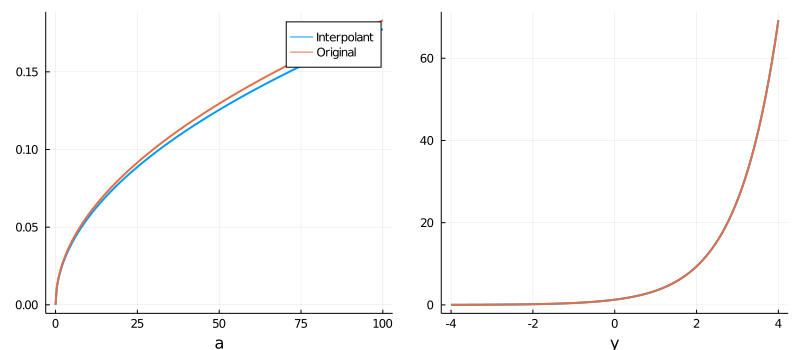

In [8]:
plt_a = plot(agridf, [interp[1:length(agridf)] yf[1:length(agridf)]], 
             label=["Interpolant" "Original"],
             lw=2,
             xlabel="a")
plt_y = plot(ygridf, [interp[5:length(agridf):end] yf[5:length(agridf):end]], 
             label="",
             lw=2,
             xlabel="y")
plot(plt_a, plt_y, layout=(1, 2), size=(800, 350))

Now, let's suppose we want to change the interpolation range of `y`, but keep the values of `a` the same. We can do this with minimal calculations by taking advantage of the `Direct` representation of the `BasisMatrix`. We just need to store the `a` part of the interpolation and then compute the new `y` part separately.

In [9]:
Φ_direct = BasisMatrix(basis, Direct(), S, [0 0])
Φ_a = Φ_direct.vals[1]
ygrid_new = range(-8; stop=8, length=10)
S_new = gridmake(agrid, ygrid_new)
Φ_direct_new = BasisMatrix(basis[2], Direct(), S_new[:,2], 0)
Φ_y = Φ_direct_new.vals[1]
Φ_new = row_kron(Φ_y, Φ_a);

Above, we stored only the `a` part of the interpolation, from the first element of `vals` in the `Direct` representation. Then, we defined a new set of `y`'s as well as the complete corresponding set of evaluation points, `S_new`. We used these points to get a new `Direct` representation, then extracted the `y` part of this. The final basis matrix for the original set of `a` and the new set of `y` is just the tensor product of the two. Again, we can compute and plot the original function and its interpolant using this new basis matrix:

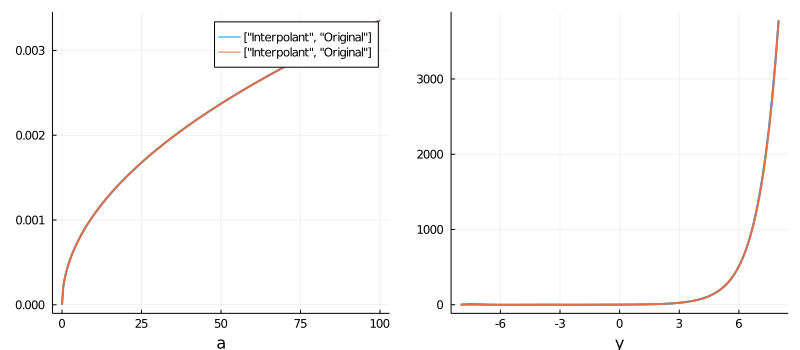

In [10]:
# Actual function at interpolation nodes
y_new = f(S_new[:,1], S_new[:, 2])

# Get coefficients
c_new = Φ_new \ y_new

# Evaluate the new interpolant
ygridf_new = range(-8; stop=8, length=100)
Sf_new = gridmake(agridf, ygridf_new)
yf_new = f(Sf_new[:, 1], Sf_new[:, 2])
interp_new = funeval(c_new, basis, Sf_new);

[interp_new[1:length(agridf)] yf_new[1:length(agridf)]]

# Plot the interpolant and the original function
plt_a = plot(agridf, [interp_new[1:length(agridf)] yf_new[1:length(agridf)]], 
             label=["Interpolant", "Original"],
             lw=2,
             xlabel="a")
plt_y = plot(ygridf_new, [interp_new[5:length(agridf):end] yf_new[5:length(agridf):end]], 
             label="",
             lw=2,
             xlabel="y")
plot(plt_a, plt_y, layout=(1, 2), size=(800, 350))

## An Economic Example

In what follows, we will show how to use `BasisMatrices.jl` to solve the Aiyagari model (see the [lecture on QuantEcon](http://lectures.quantecon.org/jl/aiyagari.html) for background info). 

### The Method

The Bellman equation we need to solve is:

$$V(a, y) = \max_{a'} u(c) + \beta \displaystyle \sum_{y' \in Y} P(y', y) V(a', y')$$
subject to 
\begin{align*}
c + a' &= (1 + r)a + wy \\
a' &> 0 \\
c &> 0
\end{align*}

To solve this, we need to first discretize the spaces of the two state variables. Let $N_a$ be the number of points for the grid over $a$ and $N_y$ be the number of grid points for $y$. Then, there will be $N = N_a N_y$ points on the state space $s$, which is a $N$ by 2 matrix of all the possible $(a, y)$ combinations. The value function at each $(a, y)$ combination can be approximated by the product of a basis function evaluated at that point and a vector of coefficients. We can stack these over all the points in $s$ to get an $N$ by $N$ basis matrix, $\mathbf{\Phi}(s)$. We can also express the expected value function (last term in the Bellman equation) in this way, with coefficients $c^e$. This gives us a system in $2N$ equations and $2N$ unknowns, which are the coefficients.

\begin{align*}
\mathbf{\Phi}(s) c &= \max_{a' \in [0, (1+r)a + wy]} \mathbf{u}(s, a') + \beta \mathbf{\Phi}([a' s_2]) c^e \\
\mathbf{\Phi}(s) c^e &= P \otimes I_{N_a} \mathbf{\Phi}(s) c
\end{align*}

We can solve using an iterative method: guess a set of coefficients $[c, c_e]'$, solve the right-hand side of the Bellman equation, and then invert $\mathbf{\Phi}(s)$ to update the guess of the coefficients until convergence. `BasisMatrices.jl` can efficiently set up and evaluate the basis matrices.

### Code

The following block of code simply defines the type that stores the parameters of the household problem, the state space, the basis matrices, and eventually, the coefficient solution.

In [11]:
using SparseArrays
using LinearAlgebra

struct Household{B<:Basis,BM<:BasisMatrix}
    r::Float64
    w::Float64
    β::Float64
    y_chain::MarkovChain{Float64, Matrix{Float64}, Vector{Float64}}
    amin::Float64
    amax::Float64
    asize::Int64
    curv::Float64
    order::Int64
    P::Matrix{Float64}
    ygrid0::Vector{Float64}
    agrid0::Vector{Float64}
    ygrid::Vector{Float64}
    agrid::Vector{Float64}
    s::Matrix{Float64}
    Ny::Int64
    Na::Int64
    Ns::Int64
    basis::B
    bs::BM
    Φ::SparseMatrixCSC{Float64,Int64}
    Emat::SparseMatrixCSC{Float64,Int64}
    Φy::SparseMatrixCSC{Float64,Int64}
    c1::Vector{Float64}
    c2::Vector{Float64}
end

The constructor sets up the grids and the basis matrices. We use a Spline basis here that is linear in the $y$ dimension (we are assuming that the income shock can only take on the two values from the Markov chain) and of order 3 (cubic) in the $a$ dimension by default. 

Notice that we save the $y$ part of the interpolation in its `Direct` form, because we will need it later when we need to evaluate the basis matrix over new `a` spaces.

In [12]:
function Household(;r::Float64=0.03, w::Float64=1.35, β::Float64=0.96,
                   y_chain::MarkovChain{Float64,Matrix{Float64},Vector{Float64}}=MarkovChain([0.67 0.33; 0.33 0.67], [0.5; 1.5]), 
                   amin::Float64=1e-10, amax::Float64=20.0, asize::Int64=7,
                   curv::Float64=1.0, order::Int64=3)

    # State space for idiosyncratic shocks
    P = y_chain.p
    ygrid0 = y_chain.state_values

    # State space for assets (endogenous)
    agrid0 = range(amin^curv; stop=amax^curv, length=asize).^(1/curv)

    # Define the basis over the state variables
    basis = Basis(SplineParams(agrid0, 0, order),
                  SplineParams(ygrid0, 0, 1))
    s, (agrid, ygrid) = nodes(basis)
    Ns, Na, Ny = size(s, 1), size(agrid, 1), size(ygrid, 1)

    # Compute the basis matrix and expectations matrix
    bs = BasisMatrix(basis, Direct(), s, [0 0])
    Φ = convert(Expanded, bs).vals[1]
    Emat = kron(P, sparse(I,Na,Na))*Φ

    # Save just the y part of the interpolation
    Φy = bs.vals[2] 

    # Initial guess for coefficients on value and expected value function
    c1 = zeros(Ns, )
    c2 = zeros(Ns, )
    
    return Household(r, w, β, y_chain, amin, amax, asize, curv, order, P,
    ygrid0, agrid0, ygrid, agrid, s, Ny, Na, Ns, basis, bs, Φ, Emat, Φy, c1,
    c2)
end

Household

Next is just a simple utility function that evaluates utility at all points in `s` for a given set of `ap` points representing the asset choice. It makes sure that if consumption is less than zero, the agent gets a very low utility (since `log` won't evaluate for negative values).

In [13]:
function utility(h::Household, s::Matrix{Float64}, ap::Vector{Float64})
    c = (1 + h.r).*s[:, 1] + h.w.*s[:, 2] - ap
    u = similar(c)
    fill!(u, 0)
    for cc=1:length(c)
        if c[cc] <= 0
            u[cc] = -10000000
        else
            u[cc] = log(c[cc])
        end
    end
    return u
end

utility (generic function with 1 method)

The function below evaluates the right-hand side of the value function on the state space for a given `ap`. This is where we take advantage of the basis matrix for `y` that was saved before. This function defines a new basis matrix for the `ap` vector that is entered. Then to evaluate the matrix at these new points, it just needs to take tensor product of the separate basis matrices.

In [14]:
function value(h::Household, s::Matrix{Float64}, ap::Vector{Float64})

    # Compute flow payoff
    u = utility(h, s, ap)

    # Basis matrix for continuation value
    bs_new = BasisMatrix(h.basis[1], Direct(), ap, 0)
    Φa = bs_new.vals[1]
    Φapy = row_kron(h.Φy, Φa)

    # Compute value
    v1 = u + h.β*Φapy*h.c2

    return v1
end

value (generic function with 1 method)

The following solves the maximization problem over next period's assets using `golden_method`. In the end, it returns the maximized value of the value function, the optimal asset holdings, and the expected value function given the current coefficient guess.

In [15]:
function opt_value(h::Household, s::Matrix{Float64})

    # Solve maximization problem
    lower_bound = zeros(size(s, 1), )
    upper_bound = (1 + h.r).*s[:, 1] + h.w.*s[:, 2]
    f(ap) = value(h, s, ap)
    ap, v1 = golden_method(f, lower_bound, upper_bound)

    # Compute expected value function
    v2 = h.Emat*h.c1

    return v1, v2, ap
end

opt_value (generic function with 1 method)

The last two functions simply iterate on the system and update the coefficient guesses (`iteration!`) and then repeat until convergence (`vfi!`).

In [16]:
function iteration!(h::Household)

    # Compute values
    s = h.s
    v1, v2, ap = opt_value(h, s)

    # Update coefficients
    c1 = h.Φ\v1
    c2 = h.Φ\v2
    h.c1 .= c1
    h.c2 .= c2

    return nothing
end

function vfi!(h; tol::Float64=1e-8, print::Bool=true)

    i = 0
    dc = 1
    while dc > tol
        i = i + 1
        c_old = [h.c1; h.c2]
        iteration!(h)
        c_new = [h.c1; h.c2]
        dc = norm(c_new - c_old)/norm(c_old)
        if print
            println("Iteration $(i); distance of $(dc)")
        end
    end
    println("Converged in $(i) iterations.")
    
    return nothing
end


vfi! (generic function with 1 method)

Let's set up a `Household` object, solve the problem, and plot the asset and consumption policies on the state space.

In [17]:
h = Household()
vfi!(h; print=false)
v1, v2, ap = opt_value(h, h.s)
c = (1 + h.r).*h.s[:, 1] + h.w.*h.s[:, 2] - ap;

Converged in 699 iterations.


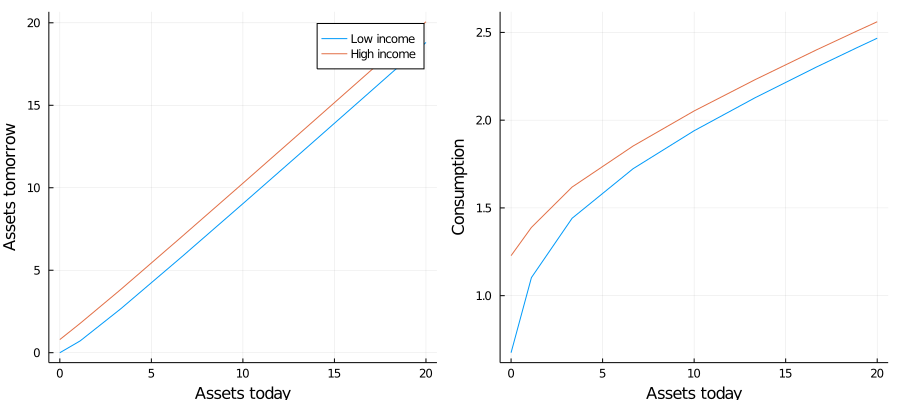

In [18]:
plot_a = plot(h.agrid, reshape(ap, h.Na, 2), labels=["Low income" "High income"],
xlabel="Assets today", ylabel="Assets tomorrow")
plot_c = plot(h.agrid, reshape(c, h.Na, 2), labels=["" ""],
xlabel="Assets today", ylabel="Consumption")
plot(plot_a, plot_c, layout=(1,2), size=(900,400))